# Exploratory Salary Analysis

In this study, we will analyse yearly salary data from [levels.fyi](http://levels.fyi).

The tech jobs market, especially related to artificial intelligence and data science is likely to continue growing exponentially. Although compensation data is available online, it is scarce. It is very likely to miss an exact contextual match, given the experience, role level at the specific company, and location (especially for outside California). Besides, the compensation structure varies a lot, e.g. some companies do not give equity. The community lacks a tool for assessing if the offer is fair, given the context.

This notebook underpins the model creation and training. The experimental data will be cleaned and preprocessed to address issues related to missing values and numerical inconsistencies in compensation data, that can affect model performance. The revealed patterns and relationships, confirm the prior on how different context influences the salary.

In [1]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pickle
import utils

from collections import Counter
from sklearn.linear_model import LinearRegression

In [2]:
SHOW_PLOTLY_PLOTS = False

## Raw dataset analysis

In [3]:
df_salary = pd.read_json('../data/salaryData.json')

In [4]:
print('There are {} data points and {} features.'.format(*df_salary.shape))
print('The avilable columns are: {}.'.format(', '.join(list(df_salary.columns))))

There are 62642 data points and 17 features.
The avilable columns are: timestamp, company, level, title, totalyearlycompensation, location, yearsofexperience, yearsatcompany, tag, basesalary, stockgrantvalue, bonus, gender, otherdetails, cityid, dmaid, rowNumber.


In [5]:
df_salary.head()

,timestamp,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,tag,basesalary,stockgrantvalue,bonus,gender,otherdetails,cityid,dmaid,rowNumber
0,2017-06-07 11:33:27,Oracle,L3,Product Manager,186,"Redwood City, CA",1,1,,160,17,9,,,7392,807,1
1,2017-06-10 17:11:29,eBay,SE 2,Software Engineer,0,"San Francisco, CA",3,4,,0,0,0,,,7419,807,2
2,2017-06-11 14:53:57,Amazon,L7,Product Manager,126,"Seattle, WA",10,0,,126,0,0,,,11527,819,3
3,2017-06-14 21:22:25,Microsoft,64,Software Engineering Manager,171348,"Redmond, WA",13,13,,92799,55371,23178,,,11521,819,5
4,2017-06-16 10:44:01,Amazon,L5,Software Engineer,214175,"Vancouver, BC, Canada",13,1,,156335,0,57840,,,1320,0,6


## Dataset preprocessing

Below, the dataset columns will be dropped or renamed and samples will be deleted if duplicated or if containing NaNs.

In [6]:
# Column preprocessing

# Renaming
df_salary.rename(
    columns={
        "totalyearlycompensation": "tyc",
        "yearsofexperience": "yoe",
        "yearsatcompany": "yac",
        "basesalary": "base",
        "stockgrantvalue": "equity"
    },
    inplace=True
);

# Removing
columns_to_drop = ['cityid', 'dmaid', 'rowNumber', 'tag', 'otherdetails']
df_salary.drop(columns_to_drop, axis=1, inplace=True);

In [7]:
# Row preprocessing

# Drop NaNs
df_salary.dropna(inplace=True);

# Drop duplicates:
df_salary.drop_duplicates(inplace=True);

In [8]:
print('There are {} data points after duplication removal and {} features.'.format(*df_salary.shape))
print('The avilable columns are: {}.'.format(', '.join(list(df_salary.columns))))

There are 62641 data points after duplication removal and 12 features.
The avilable columns are: timestamp, company, level, title, tyc, location, yoe, yac, base, equity, bonus, gender.


## Exploring features

Below, each feature is analysed. Insights will help with feature selection and model training.

### Target Variable: Total Yearly Compensation

In [9]:
# Sanity check if total compensation equals sum across base, equity and bonus.

(df_salary['tyc'] == df_salary['base']+df_salary['equity']+df_salary['bonus']).all()

True

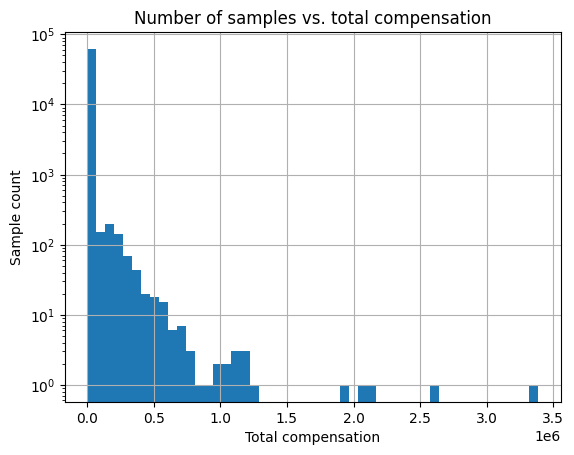

In [10]:
# Finding out what is the compensation distribution

fig, ax = plt.subplots()
df_salary['tyc'].hist(bins=50)
ax.set_yscale('log')
ax.set_ylabel('Sample count')
ax.set_xlabel('Total compensation')
plt.title('Number of samples vs. total compensation');

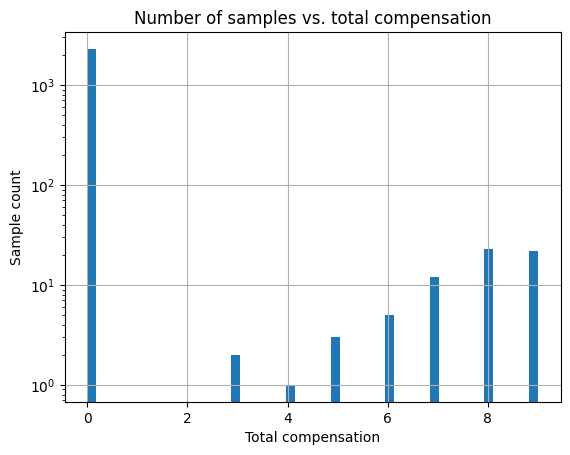

In [11]:
# Zooming in on total compensation

fig, ax = plt.subplots()
df_salary[df_salary['tyc'] < 10]['tyc'].hist(bins=50);
ax.set_yscale('log')
ax.set_ylabel('Sample count')
ax.set_xlabel('Total compensation')
plt.title('Number of samples vs. total compensation');

There are 60345 data points after dropping uninformative samples.


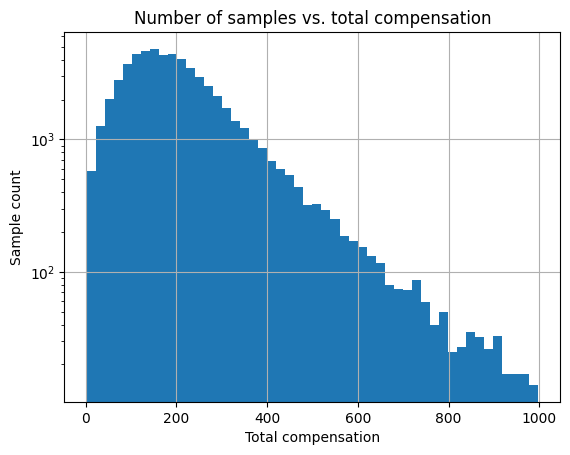

In [12]:
# Dropping zero total compeansation

df_salary = df_salary[df_salary['tyc'] != 0]

print('There are {} data points after dropping uninformative samples.'.format(*df_salary.shape))

fig, ax = plt.subplots()
df_salary[df_salary['tyc'] < 1000]['tyc'].hist(bins=50);
ax.set_yscale('log')
ax.set_ylabel('Sample count')
ax.set_xlabel('Total compensation')
plt.title('Number of samples vs. total compensation');

In [13]:
# Identifying the issue in the dataset: inconsistency in compensation reports

df_salary[df_salary['tyc']>1000].sort_values('tyc').tail(60)

,timestamp,company,level,title,tyc,location,yoe,yac,base,equity,bonus,gender
333,2018-03-07 12:25:06,Amazon,L5,Software Engineer,498841,"Seattle, WA",18,1,147083,295543,56215,
822,2018-06-12 20:54:06,Google,T6,Data Scientist,503119,"Kirkland, WA",30,3,252028,180159,70932,Male
660,2018-05-24 12:26:32,Amazon,L5,Software Engineer,504189,"Seattle, WA",4,1,109769,293763,100657,Male
1015,2018-07-13 14:38:27,Amazon,6,Software Engineering Manager,507404,"Seattle, WA",11,15,222096,285308,0,Male
434,2018-04-11 13:46:43,Google,Staff,Software Engineer,513058,"Mountain View, CA",6,4,257759,192590,62709,
994,2018-07-10 20:54:29,Amazon,L6,Software Engineer,523846,"Sunnyvale, CA",4,9,240903,282943,0,Male
818,2018-06-12 16:39:31,Uber,L4,Software Engineer,527293,"San Francisco, CA",2,0,217779,296132,13382,Male
531,2018-05-07 18:55:59,Facebook,E3,Software Engineer,530550,"Menlo Park, CA",0,0,129308,325720,75522,Male
210,2018-01-13 18:38:02,Amazon,L5,Software Engineer,531497,"Seattle, WA",2,1,198457,254440,78600,
386,2018-03-28 20:03:43,Twitter,Senior Staff,Software Engineer,532770,"San Francisco, CA",15,4,264243,252379,16148,


In [14]:
# At least two datapoints reported monthly salary instead of yearly
df_salary.loc[42, 'base'] = df_salary.loc[42, 'base']*12
df_salary.loc[330, 'base'] = df_salary.loc[330, 'base']*12
df_salary.loc[330, 'equity'] = df_salary.loc[330, 'equity']*12

# Make resonable guess which data to scale by 1000
df_salary['bonus'] = df_salary['bonus'].apply(lambda x: round(x / 1000) if x > 600 else x)
df_salary['equity'] = df_salary['equity'].apply(
    lambda x: round(x / 1000) if x > 1100 and \
    x not in [5716, 4268, 3141, 3062, 2452, 2426, 2411, 2297,
              1989, 1858, 1634, 1630, 1621, 1590, 1581, 1503,
              1472, 1470, 1440, 1429, 1320, 1201, 1178, 1139,
              1113, 1106, 1100, 1099, 1085, 1084, 1083] else x)
df_salary['base'] = df_salary['base'].apply(lambda x: round(x / 1000) if x > 10000 else x)
df_salary['tyc'] = df_salary['base'] + df_salary['equity'] + df_salary['bonus']

#### Target Variables: Base Salary, Equity and Bonus

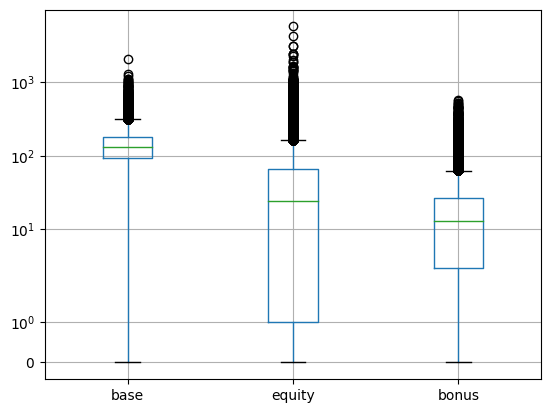

In [15]:
# Compare contibution of base, equity and bonus components

fig, ax = plt.subplots()
df_salary.boxplot(['base', 'equity', 'bonus'])
ax.set_yscale('symlog')

**Comments**: *The target variable, i.e. total yearly compensation, is a sum over base salary, equity and bonus. A lot of employees reported zero total compensation which clearly useless data which was removed from the dataset. The most important observation in this analysis is that compensation is reported in thousands or absolute numbers. This is very complicated to handlde as 1000 in bonus could mean 1M\\$ or 1k\\$. For now, reasonable assumptions were made to correct this. After the corrections a gamma distribuion is observed, which is expected (a long tail with outliers on the high compensation side. Finally, base salary is higher on average than equity compensation as expected (and similary equity compensation is higher than the bonus).*

In [16]:
df_salary.sort_values('tyc').head(50)

,timestamp,company,level,title,tyc,location,yoe,yac,base,equity,bonus,gender
14321,2019-11-28 13:47:26,Andela,E1,Software Engineer,3,"Lagos, LA, Nigeria",6,1,3,0,0,Male
40839,2021-01-22 10:44:24,Infosys,Senior Systems Engineer,Software Engineer,3,"Bangalore, KA, India",2,1,3,0,0,Male
22082,2020-05-20 17:44:06,Accenture,Software Engineer Analyst,Software Engineer,4,"Bangalore, KA, India",2,1,3,0,1,Male
38766,2020-12-22 20:59:41,Ernst and Young,Staff,Software Engineer,5,"Thiruvananthapuram, KL, India",2,1,5,0,0,Male
12911,2019-10-17 01:59:32,Andela,E1,Software Engineer,5,"Lagos, LA, Nigeria",5,1,5,0,0,
11548,2019-09-13 23:32:49,Citrix Systems Inc,Senior Product Manager 2,Product Manager,5,"Bengaluru, KA, India",17,1,0,0,5,Male
36711,2020-11-24 02:57:36,Tata Consultancy Services,SE,Software Engineer,6,"Pune, MH, India",4,6,4,1,1,Male
54401,2021-06-06 18:12:43,HP,Software engineer,Software Engineer,6,"Bangalore, KA, India",0,0,5,1,0,Male
42184,2021-02-06 10:37:57,Bosch,trainee,Mechanical Engineer,6,"Budapest, BU, Hungary",2,1,6,0,0,Male
35705,2020-11-09 23:34:11,Oracle,IC-1,Software Engineer,6,"Bangalore, KA, India",1,1,6,0,0,Male


### Timestamp

In [17]:
time_data = df_salary['timestamp'].describe(datetime_is_numeric=True);

print('The avilable data covers the period between {:%B %d, %Y} and {:%B %d, %Y}.'.format(
    time_data['min'],
    time_data['max']
))

The avilable data covers the period between June 07, 2017 and August 17, 2021.


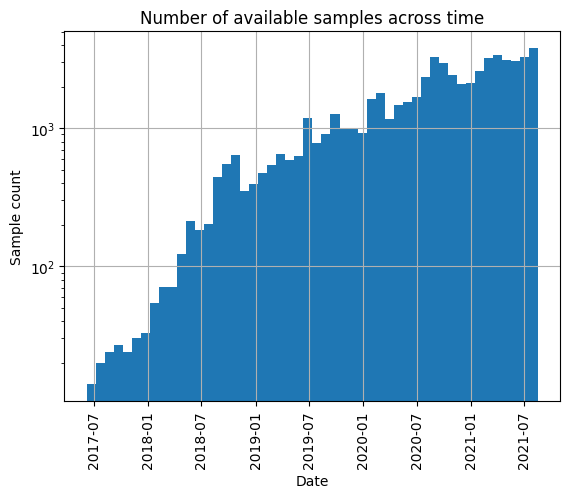

In [18]:
fig, ax = plt.subplots()
df_salary['timestamp'].hist(bins=50)
ax.set_yscale('log')
ax.set_ylabel('Sample count')
ax.set_xlabel('Date')
plt.title('Number of available samples across time')
plt.xticks(rotation=90);

In [19]:
if SHOW_PLOTLY_PLOTS:
    df_salary['year'] = df_salary["timestamp"].dt.year

    fig = px.violin(
        df_salary,
        x='year',
        y='tyc',
        color='year',
        labels={
            "year": "Year",
            "tyc": "Total compensation"
        },
        title="Total yearly compensation grouped by year",
        violinmode='overlay',
        box=True)
    fig.show()

**Comments**: *The number of samples grows as the popularity of the levels.fyi grows as well, which is expected. The website requires to submit your current salary in order to view other data. There is some cyclicality related to the hiring cycle across the year: May and September peaks. Also, the salaries seem to drop with time, i.e. it is possible that there is bias in reported salaries.*

### Company

In [20]:
# Preprocess company name

print('Number of companies before processing: {}.'.format(len(df_salary['company'].unique())))

# String preprocessing: removing white spaces
df_salary['company'] = df_salary['company'].str.strip()

# String preprocessing: lower-case company name
df_salary['company'] = df_salary['company'].str.lower()

print('Number of companies after processing: {}.'.format(len(df_salary['company'].unique())))

Number of companies before processing: 1842.
Number of companies after processing: 1101.


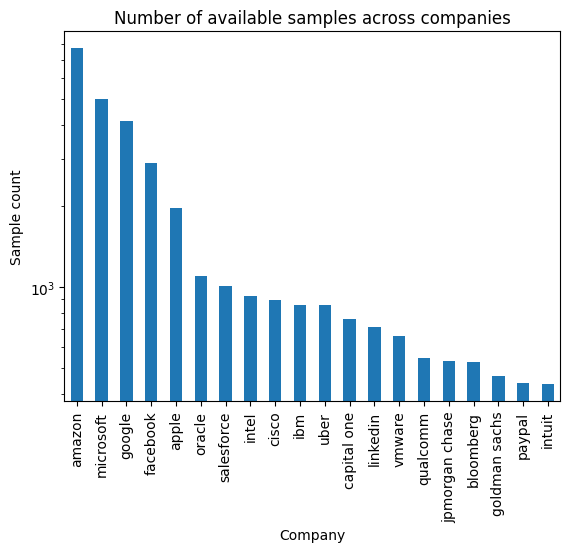

In [21]:
# Visualize the most popular comanies

counter = Counter(df_salary['company'])
df = pd.DataFrame.from_dict(dict(counter.most_common()[:20]), orient='index')
df.plot(kind='bar',
        logy=True,
        legend=False,
        xlabel='Company',
        ylabel='Sample count',
        title='Number of available samples across companies');
plt.xticks(rotation=90);

In [22]:
company_corrections = [
    ('akamai technologies', 'akamai'),
    ('amazon web services', 'amazon'),
    ('amazon.com', 'amazon'),
    ('amzon', 'amazon'),
    ('apple inc.', 'apple'),
    ('arista', 'arista networks'),
    ('aruba', 'aruba networks'),
    ('aws', 'amazon'),
    ('bain & company', 'bain'),
    ('bank of america merrill lynch', 'bank of america'),
    ('bcg', 'bcg digital ventures'),
    ('bloomberg', 'bloomberg lp'),
    ('bolt (eu)', 'bolt'),
    ('booking', 'booking.com'),
    ('bosch global', 'bosch'),
    ('caci international', 'caci'),
    ('cadence design systems', 'cadence'),
    ('cgi', 'cgi group'),
    ('cisco meraki', 'cisco'),
    ('cisco systems', 'cisco'),
    ('citi', 'citibank'),
    ('cognizant technology solutions', 'cognizant'),
    ('costco wholesale','costco'),
    ('coupa','coupa software'),
    ('dell technologies', 'dell'),
    ('deloitte advisory', 'deloitte'),
    ('deloitte consulting', 'deloitte'),
    ('deloitte consulting llp', 'deloitte'),
    ('discover', 'discover financial services'),
    ('dish', 'dish network'),
    ('disney streaming services', 'disney'),
    ('epam', 'epam systems'),
    ('ernst and young', 'ernst & young'),
    ('ey-parthenon', 'ey'),
    ('ford motor', 'ford'),
    ('ford motor company', 'ford'),
    ('ge aviation', 'ge'),
    ('ge digital', 'ge'),
    ('ge healthcare', 'ge'),
    ('gojek tech', 'gojek'),
    ('google llc', 'google'),
    ('here technologies', 'here'),
    ('hewlett packard enterprise', 'hp'),
    ('hp inc', 'hp'),
    ('infosys ltd', 'infosys'),
    ('intel corporation', 'intel'),
    ('jane street capital', 'jane street'),
    ('johnson', 'johnson & johnson'),
    ('johnson and johnson','johnson & johnson'),
    ('jp morgan chase', 'jp morgan'),
    ('jpmorgan', 'jp morgan'),
    ('jpmorgan chase', 'jp morgan'),
    ('l3harris technologies', 'l3harris'),
    ('liberty mutual insurance', 'liberty mutual'),
    ('lowes', "lowe's"),
    ('lucid motors', 'lucid'),
    ('lucid software', 'lucid'),
    ("macy's,", "macy's"),
    ('mckinsey', 'mckinsey & company'),
    ('microchip technology', 'microchip'),
    ('micron', 'micron technology'),
    ('microsoft corporation', 'microsoft'),
    ("moody's analytics", "moody's"),
    ('nuance communications', 'nuance'),
    ('nxp semiconductors', 'nxp'),
    ('oscar health', 'oscar'),
    ('panasonic avionics', 'panasonic'),
    ('procore technologies', 'procore'),
    ('qualcomm inc', 'qualcomm'),
    ('raytheon technologies', 'raytheon'),
    ('samsung electronics america', 'samsung'),
    ('samsung research america', 'samsung'),
    ('sap concur', 'sap'),
    ('sas institute', 'sas'),
    ('sas software', 'sas'),
    ('snapchat', 'snap'),
    ('sony interactive entertainment', 'sony'),
    ('strategy by pwc', 'pwc'), 
    ('verizon media', 'verizon'),
    ( 'zs associates',  'zs'),
    ('zillow group', 'zillow'),
    ('wipro limited', 'wipro'),
    ('walmart labs', 'walmart'),
    ('visa inc', 'visa'),
    ('the walt disney company', 'disney')
]

for old, new in company_corrections:
    df_salary.replace(old, new, inplace=True)

In [23]:
df_salary.drop(df_salary[df_salary['company'].isin(['test', 'n/a', 'startup'])].index, inplace=True)

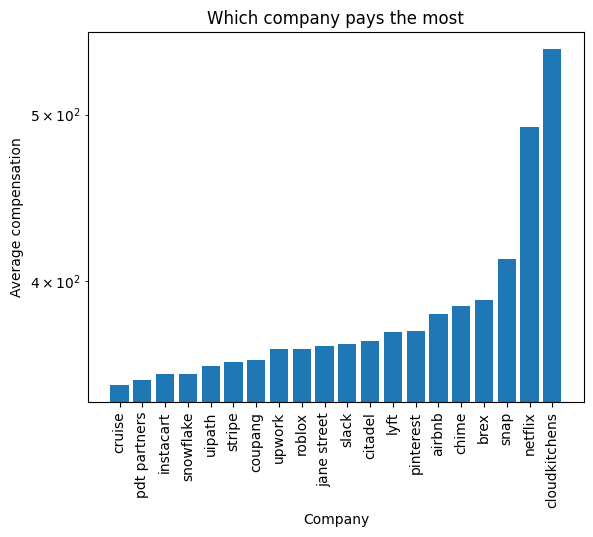

In [24]:
# Which company pays the most?

fig, ax = plt.subplots()
tmp_data = df_salary.groupby('company')['tyc'].mean().sort_values()[-20:]
plt.bar(tmp_data.keys(), tmp_data.values)
plt.xticks(rotation=90);
ax.set_yscale('log')
ax.set_ylabel('Average compensation')
ax.set_xlabel('Company')
plt.title('Which company pays the most')
plt.xticks(rotation=90);

**Comments**: *The highest number of submission comes from big tech such as Amazon, Microsoft, Google, Facebook and Apple. This is expected, these are the biggest companies.*

### Title

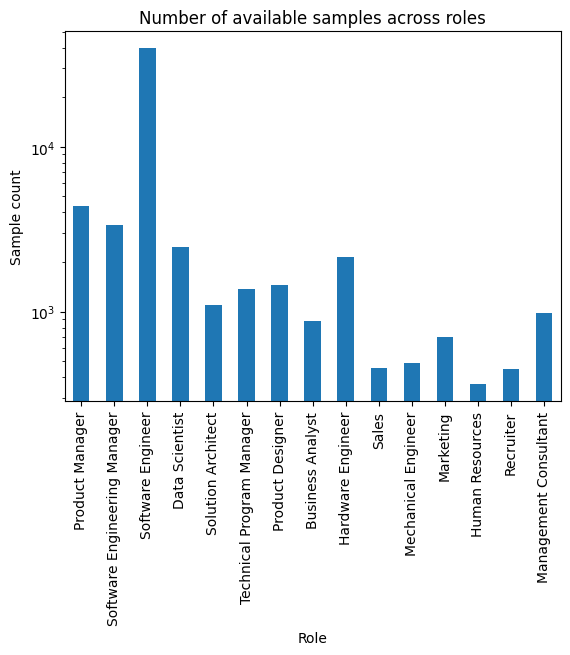

In [25]:
counter = Counter(df_salary['title'])
df = pd.DataFrame.from_dict(counter, orient='index')
df.plot(kind='bar',
        logy=True,
        legend=False,
        xlabel='Role',
        ylabel='Sample count',
        title='Number of available samples across roles');
plt.xticks(rotation=90);

The tool will target software developers and data scientists. The dataset will be cleaned from other roles.

In [26]:
# Drop samples

df_salary = df_salary[df_salary['title'].isin(['Software Engineer', 'Data Scientist'])]
print('Number of remaining data points: {} after role filtering.'.format(*df_salary.shape))

Number of remaining data points: 42158 after role filtering.


**Comments**: *Ideally the dataset should be limited to data scientists but that would limit the dataset to 2000 samples. Software Engineering jobs are still a good proxy for data scientists salaries. The tool should be extended to other buisness roles in the future. However right now, it is beyond the scope of the project.*

### Level

The naming and levelling across different companies varies a lot. This should be accounted for in the model training.

In [27]:
# TODO: Unify levels between companies

### Years of Experience

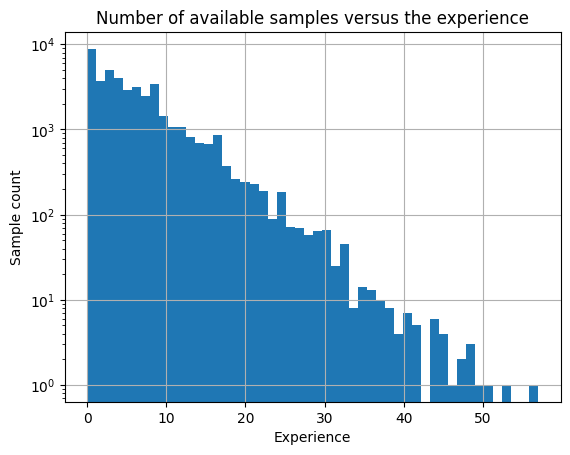

In [28]:
fig, ax = plt.subplots()
df_salary['yoe'].hist(bins=50);
ax.set_yscale('log')
ax.set_ylabel('Sample count')
ax.set_xlabel('Experience')
plt.title('Number of available samples versus the experience');

In [29]:
# Take a closer look at the outliers with over 50 years if experience

df_salary[df_salary['yoe'] > 50]

,timestamp,company,level,title,tyc,location,yoe,yac,base,equity,bonus,gender
8388,2019-06-17 06:53:44,oracle,IC-5,Software Engineer,341,"Redwood City, CA",57,12,292,49,0,
33950,2020-10-19 06:33:21,ibm,Band 9,Software Engineer,151,"New York, NY",51,8,147,4,0,Male
41218,2021-01-26 14:51:02,intel,L9,Software Engineer,170,"Hillsboro, OR",53,30,94,28,48,Male


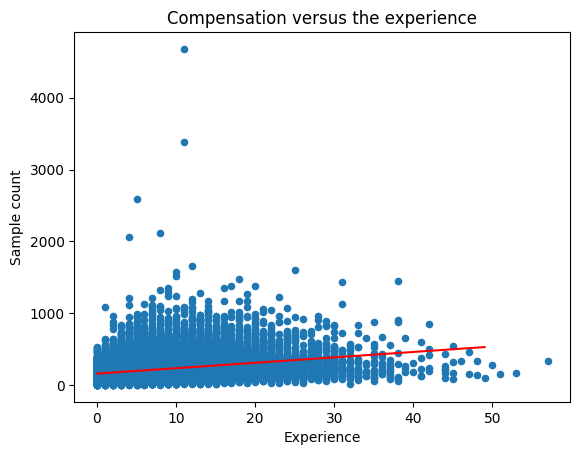

In [30]:
# Show the correlation between experience and compensation

reg = LinearRegression().fit(X=df_salary['yoe'].values.reshape(-1, 1), y=df_salary['tyc'].values.reshape(-1, 1))
pred = reg.predict(np.arange(0, 50, 1).reshape(-1, 1))
df_salary.plot.scatter(
    x='yoe',
    y='tyc',
    xlabel='Experience',
    ylabel='Sample count',
    title='Compensation versus the experience'
)
plt.plot(np.arange(0, 50, 1), pred, 'r');

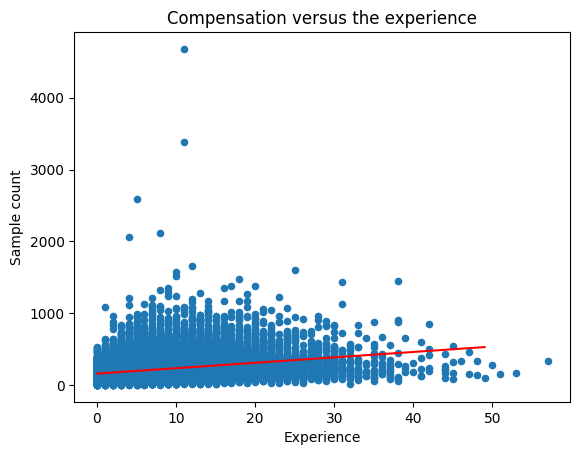

In [31]:
# Show the correlation between experience and compensation

reg = LinearRegression().fit(X=df_salary['yoe'].values.reshape(-1, 1), y=df_salary['tyc'].values.reshape(-1, 1))
pred = reg.predict(np.arange(0, 50, 1).reshape(-1, 1))
df_salary.plot.scatter(
    x='yoe',
    y='tyc',
    xlabel='Experience',
    ylabel='Sample count',
    title='Compensation versus the experience'
)
plt.plot(np.arange(0, 50, 1), pred, 'r');

In [32]:
# Export baseline model

with open("../models/baseline-lr.pkl", "wb") as f:
    pickle.dump(reg, f)

**Comments**: *The number of available samples goes down with the reported experience which is expected. The relationship between compensation and experience is positive, which is not a surprise either. However, the outliers, i.e. employees with over 50 years of experience have surprisingly low compensation.*

### Location

In [33]:
# Drop city names: limits the input to countries or U.S. states

df_salary['location'] = df_salary['location'].str.split(',').str[-1].str.strip()

# Replace the names of the countries
country_corrections = [
    ('Hong Kong (SAR)', 'Hong Kong'),
    ('South', 'South Africa'),
    ('Yugoslavia','Serbia'),
    ('Netherlands Antilles', 'Netherlands')
]

for old, new in country_corrections:
    df_salary.replace(old, new, inplace=True)

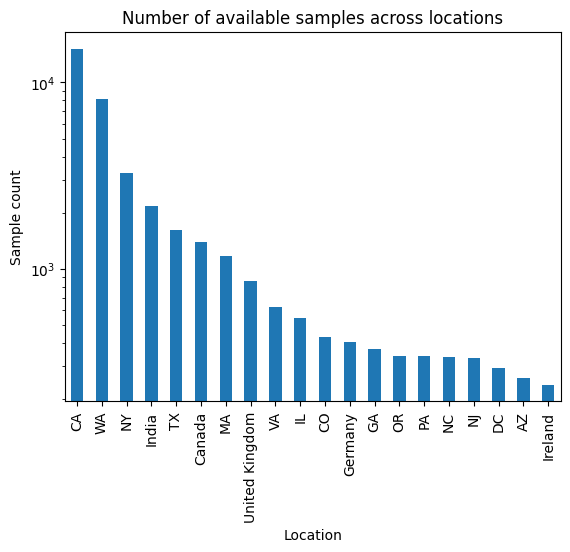

In [34]:
# Check number of samples across locations

counter = Counter(df_salary['location'])
df = pd.DataFrame.from_dict(dict(counter.most_common()[:20]), orient='index')
df.plot(kind='bar',
        logy=True,
        legend=False,
        xlabel='Location',
        ylabel='Sample count',
        title='Number of available samples across locations');

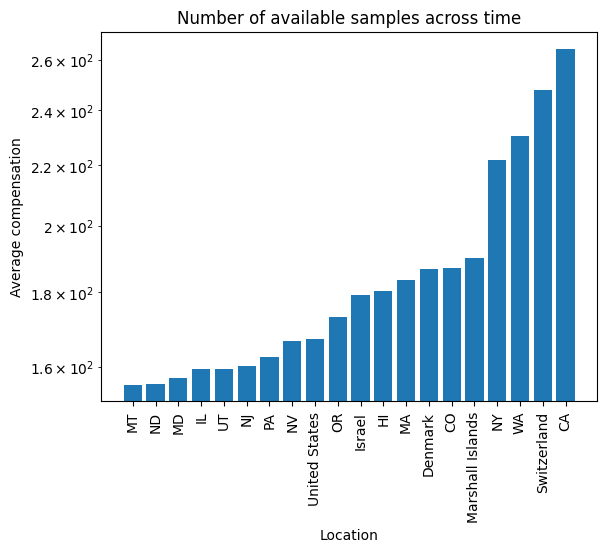

In [35]:
# Check average compensation across different countries

fig, ax = plt.subplots()
tmp_data = df_salary.groupby('location')['tyc'].mean().sort_values()[-20:]
plt.bar(tmp_data.keys(), tmp_data.values)
plt.xticks(rotation=90);
ax.set_yscale('log')
ax.set_ylabel('Average compensation')
ax.set_xlabel('Location')
plt.title('Number of available samples across time')
plt.xticks(rotation=90);

**Comments**: *Most of the samples come from California (or U.S.) as expected. However the average compensation across different states veries a lot, often surpased by states such as Switzerland. Location seems to be one of the most important features in the dataset.*

### Years at Company

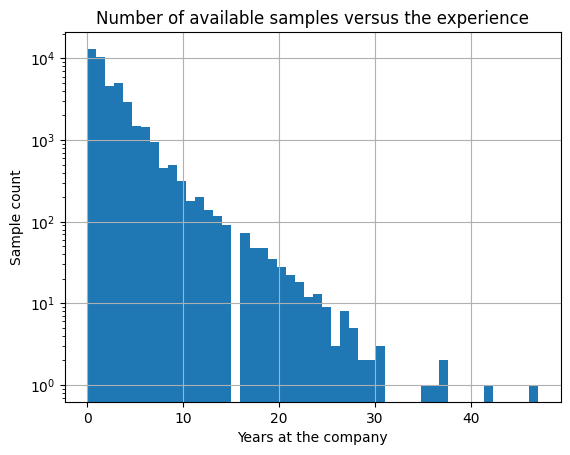

In [36]:
fig, ax = plt.subplots()
df_salary['yac'].hist(bins=50);
ax.set_yscale('log')
ax.set_ylabel('Sample count')
ax.set_xlabel('Years at the company')
plt.title('Number of available samples versus the experience');

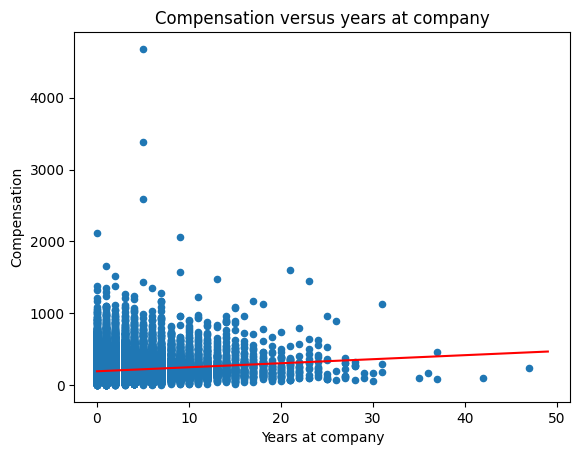

In [37]:
# Show the correlation between years at the company and compansation

reg = LinearRegression().fit(X=df_salary['yac'].values.reshape(-1, 1), y=df_salary['tyc'].values.reshape(-1, 1))
pred = reg.predict(np.arange(0,50,1).reshape(-1, 1))
df_salary.plot.scatter(
    x='yac',
    y='tyc',
    xlabel='Years at company',
    ylabel='Compensation',
    title='Compensation versus years at company'
)
plt.plot(np.arange(0,50,1), pred, 'r');

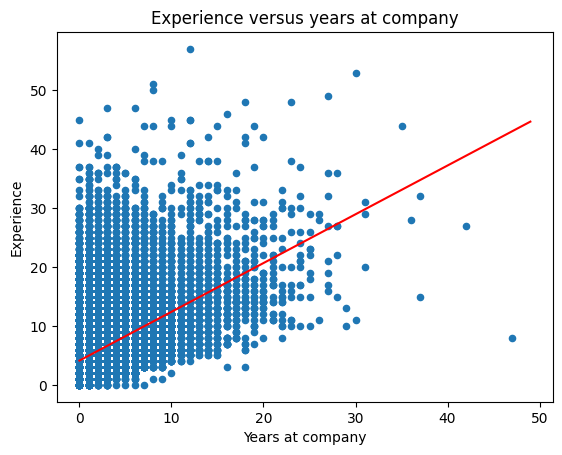

In [38]:
# Show the correlation between years at the company and experience

reg = LinearRegression().fit(X=df_salary['yac'].values.reshape(-1, 1), y=df_salary['yoe'].values.reshape(-1, 1))
pred = reg.predict(np.arange(0,50,1).reshape(-1, 1))
df_salary.plot.scatter(
    x='yac',
    y='yoe',
    xlabel='Years at company',
    ylabel='Experience',
    title='Experience versus years at company'
)
plt.plot(np.arange(0,50,1), pred, 'r');

**Comments**: *As the years at company grows, the number of samples decreases. Years at company is positively correlated with compensation and experience. All of these observations are expected.*

### Gender

In [39]:
# Gender frequency in the dataset
if SHOW_PLOTLY_PLOTS:
    fig = px.pie(
        df_salary,
        names='gender'
    )
    fig.show()

In [40]:
# Clean the gender data 
df_salary.replace('Title: Senior Software Engineer', '', inplace=True)

# Fix the missing values using mode imputaton
df_salary.replace('', 'Male', inplace=True)

In [41]:
if SHOW_PLOTLY_PLOTS:
    fig = px.violin(
        df_salary,
        x='gender',
        y='tyc',
        color='gender',
        labels={
            "gender": "Gender",
            "tyc": "Total compensation"
        },
        title="Total yearly compensation grouped by gender",
        violinmode='overlay',
        box=True)
    fig.show()

## Export the dataset

In [45]:
df_coli2022 = pd.read_csv('../data/cost-of-living-index-2022.csv')

df_coli2022.drop(
    [
        'Rank',
        'Rent Index',
        'Cost of Living Plus Rent Index',
        'Groceries Index',
        'Restaurant Price Index',
        'Local Purchasing Power Index'
    ],
    axis=1,
    inplace=True
)

df_coli2022.rename(
    columns={
        "Country": "location",
        "Cost of Living Index": "coli"
    },
    inplace=True
);

df_colibs2022 = pd.read_csv('../data/cost-of-living-index-by-state-2022.csv')

df_colibs2022.drop(
    [
        'groceryCost',
        'housingCost',
        'utilitiesCost',
        'transportationCost',
        'miscCost'
    ],
    axis=1,
    inplace=True
);

df_colibs2022.rename(
    columns={
        "state": "location",
        "costIndex": "coli"
    },
    inplace=True
);

df_colibs2022.replace(
    utils.us_state_to_abbrev.keys(),
    utils.us_state_to_abbrev.values(),
    inplace=True
);

In [46]:
df_colibs2022['coli'] = df_colibs2022['coli'] - df_colibs2022['coli'].mean() + df_coli2022.loc[131, 'coli']

In [47]:
df_coli2022 = df_coli2022.append(df_colibs2022, ignore_index=True)

In [48]:
df_salary = df_salary.merge(df_coli2022, on='location')

In [49]:
df_salary

,timestamp,company,level,title,tyc,location,yoe,yac,base,equity,bonus,gender,coli
0,2017-06-16 10:44:01,amazon,L5,Software Engineer,214,Canada,13,1,156,0,58,Male,70.220
1,2018-05-08 14:26:34,amazon,L4,Software Engineer,108,Canada,1,1,83,1,24,Male,70.220
2,2018-05-23 08:29:33,microsoft,61,Software Engineer,127,Canada,5,1,119,4,4,Male,70.220
3,2018-05-27 22:00:45,microsoft,59,Software Engineer,145,Canada,1,1,77,49,19,Male,70.220
4,2018-06-15 22:48:07,amazon,L5,Software Engineer,194,Canada,11,1,158,0,36,Male,70.220
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41856,2021-06-29 04:04:03,epam systems,Senior Software Engineer,Software Engineer,50,Kazakhstan,12,3,50,0,0,Male,28.680
41857,2021-07-15 21:02:34,ford,SG 7,Software Engineer,61,ME,6,6,58,0,3,Male,80.518
41858,2021-07-26 09:54:27,blackhawk network,Sr Software Engineer,Software Engineer,126,ME,3,2,126,0,0,Female,80.518
41859,2021-07-21 23:13:06,epam systems,L2,Software Engineer,13,Uzbekistan,3,1,12,0,1,Male,27.310


In [52]:
df_salary.to_csv('../data/experimental_data.csv', index=False)